In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
# Build a example dataset
data = pd.DataFrame({'a':range(1000), 'b':range(1000,2000), 'y': [i/1000 for i in range(1000)]}).sample(frac=1, random_state=17).reset_index(drop=True)
data

,a,b,y
0,786,1786,0.786
1,499,1499,0.499
2,930,1930,0.930
3,217,1217,0.217
4,803,1803,0.803
...,...,...,...
995,406,1406,0.406
996,390,1390,0.390
997,143,1143,0.143
998,241,1241,0.241


In [3]:
# Split the data into train and test
X = data.drop('y', axis=1)
y = data['y']

In [4]:
X_train, y_train = X[:600], y[:600]
X_val, y_val = X[600:800], y[600:800]
X_test, y_test = X[800:], y[800:]
print(X_train.shape, X_val.shape, X_test.shape)

(600, 2) (200, 2) (200, 2)


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Torch Model

In [6]:
# Select the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3070


In [7]:
# Convert the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32, device=device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device)

In [8]:
X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([600, 2]),
 torch.Size([600]),
 torch.Size([200, 2]),
 torch.Size([200]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [9]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor,y_train_tensor),batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_tensor,y_val_tensor),batch_size=batch_size)

In [10]:
class NeuralNet(nn.Module):
    def __init__(self, params: dict):
        super().__init__()
        torch.manual_seed(17)
        
        # Build a ordered dictionary to store the model
        model_dict = OrderedDict()
        
        # Add the input layer
        model_dict['Input_layer'] = nn.Linear(params['input_shape'], params['layers'][0])
        model_dict['Input_activation'] = self.choose_activation(params['activation'][0])
        
        # Add the hidden layers
        if len(params['layers']) > 1:
            for i in range(1, len(params['layers'])):
                model_dict[f'Hidden_layer_{i}'] = nn.Linear(params['layers'][i-1], params['layers'][i])
                model_dict[f'Hidden_activation_{i}'] = self.choose_activation(params['activation'][i])
        
        # Build the model using the ordered dictionary    
        self.model = nn.Sequential(model_dict)

    def choose_activation(self, activation: str):
        """
        Choose the activation function
        
        Args:
            activation (str): the name of the activation function
        
        Returns:
            nn.Module: the activation function
        """
        
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'tanh':
            return nn.Tanh()
        elif activation == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError('Activation function not recognized')
    
    def forward(self, x: torch.Tensor):
        
        # Apply the model
        preds = self.model(x)
        
        # Squeeze the tensor
        preds = preds.squeeze()
        return preds

In [11]:
def one_epoch(model: nn.Module, loss_function: torch.nn.modules.loss, optimizer: torch.optim, metrics: list, loader: nn.Module, train:bool=True, device:str ='cpu'):
        """
        Run one epoch.
        
        Args:
            model (nn.Module): The model.
            loss_function (torch.nn.modules.loss): The loss function.
            optimizer (torch.optim): The optimizer.
            metrics (list): The metrics to use.
            loader (nn.Module): The dataloader.
            train (bool): If the model is training.
            device (str): The device to use.
        
        Returns:
            info_dict (dict): A dictionary with the information of the epoch.
        """
        
        # Create a dictionary to store the information.
        info_dict = {'Loss': []}
        info_dict.update({metric.__name__: [] for metric in metrics})
        
        # Set the model to train or eval mode.
        if train:
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
           
        for X, y in loader:
            # Move the data to the device.
            X, y = X.to(device), y.to(device)

            if train:
                optimizer.zero_grad()
            
            # Calculate the predictions and the loss.   
            pred = model(X)
            loss = loss_function(pred, y)
            
            # If the model is training, update the weights.
            if train:
                loss.backward()
                optimizer.step()
            
            # Store the loss.
            info_dict['Loss'].append(loss.item())
            
            # Calculate the metrics and store them.
            for metric in metrics:
                metric_value = metric(y.cpu().detach().numpy(), pred.cpu().detach().numpy())
                info_dict[metric.__name__].append(metric_value)
        
        # Calculate the mean loss and the mean metrics.
        info_dict = {key: np.mean(value) for key, value in info_dict.items()}
        
        # Add val prefix to the metrics if the model is not training.
        if not train:
            info_dict = {f'val_{key}': value for key, value in info_dict.items() if key != 'Epoch'}
        
        return info_dict

In [12]:
class EarlyStopping:
    def __init__(self, tolerance:int = 5, min_delta:float = 0, start_from_epoch:int = 0):

        # Set the parameters
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.start_from_epoch = start_from_epoch

    def __call__(self, epoch, train_loss, validation_loss):
        
        # Check if the validation loss is less than the train loss
        if epoch>=self.start_from_epoch and (validation_loss - train_loss) > self.min_delta:
            
            # Increase the counter
            self.counter +=1
            
            # Check if the counter is greater than the tolerance
            if self.counter >= self.tolerance:
                # Set the early stop to True  
                self.early_stop = True

In [13]:
num_epochs = 200
params={
    'input_shape': 2,
    'layers': [64, 32, 16, 1],
    'activation': ['relu', 'relu', 'tanh', 'sigmoid'],
}

In [14]:
model = NeuralNet(params).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor =0.5, min_lr=1e-7, eps=1e-08, cooldown=20)
early_stopping = EarlyStopping(tolerance=5, min_delta=1e-6, start_from_epoch=25)
metrics = [r2_score]

In [15]:
info_dict = {}

for epoch in range(num_epochs):
    
    # Add the epoch to the info_dict
    info_dict[epoch] = {}
    
    # Train the model
    info_dict[epoch].update(one_epoch(model, loss_function, optimizer, metrics, train_loader, train=True, device=device))
    
    # Validate the model
    info_dict[epoch].update(one_epoch(model, loss_function, optimizer, metrics, val_loader, train=False, device=device))
    scheduler.step(info_dict[epoch]['val_Loss'])

    # Add the learning rate
    info_dict[epoch]['lr'] = optimizer.param_groups[0]['lr']
    
    if epoch == 0 or (epoch+1) %10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(*['%s: %.4g'%(k,v) for k,v in info_dict[epoch].items()], sep=', ', end='\n')
    
    # Early stopping
    early_stopping(epoch, info_dict[epoch]['Loss'], info_dict[epoch]['val_Loss'])
    if early_stopping.early_stop:
        print('Early stopping')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(*['%s: %.4g'%(k,v) for k,v in info_dict[epoch].items()], sep=', ', end='\n')
        break

Epoch 1/200
Loss: 0.03138, r2_score: 0.5998, val_Loss: 0.01036, val_r2_score: 0.8757, lr: 0.01
Epoch 10/200
Loss: 0.0001773, r2_score: 0.9978, val_Loss: 0.0001556, val_r2_score: 0.9981, lr: 0.01
Epoch 20/200
Loss: 5.928e-05, r2_score: 0.9993, val_Loss: 5.289e-05, val_r2_score: 0.9994, lr: 0.01
Epoch 30/200
Loss: 0.0001428, r2_score: 0.9983, val_Loss: 0.0002931, val_r2_score: 0.9965, lr: 0.01
Epoch 40/200
Loss: 2.635e-05, r2_score: 0.9997, val_Loss: 2.177e-05, val_r2_score: 0.9997, lr: 0.01
Epoch 50/200
Loss: 1.735e-05, r2_score: 0.9998, val_Loss: 1.476e-05, val_r2_score: 0.9998, lr: 0.01
Epoch 60/200
Loss: 1.593e-05, r2_score: 0.9998, val_Loss: 1.27e-05, val_r2_score: 0.9998, lr: 0.01
Early stopping
Epoch 68/200
Loss: 8.769e-05, r2_score: 0.9989, val_Loss: 0.0002924, val_r2_score: 0.9965, lr: 0.01


In [16]:
test_preds = model(X_test_tensor).cpu().detach().numpy()
r2_score(y_test, test_preds)

0.9966209839322665

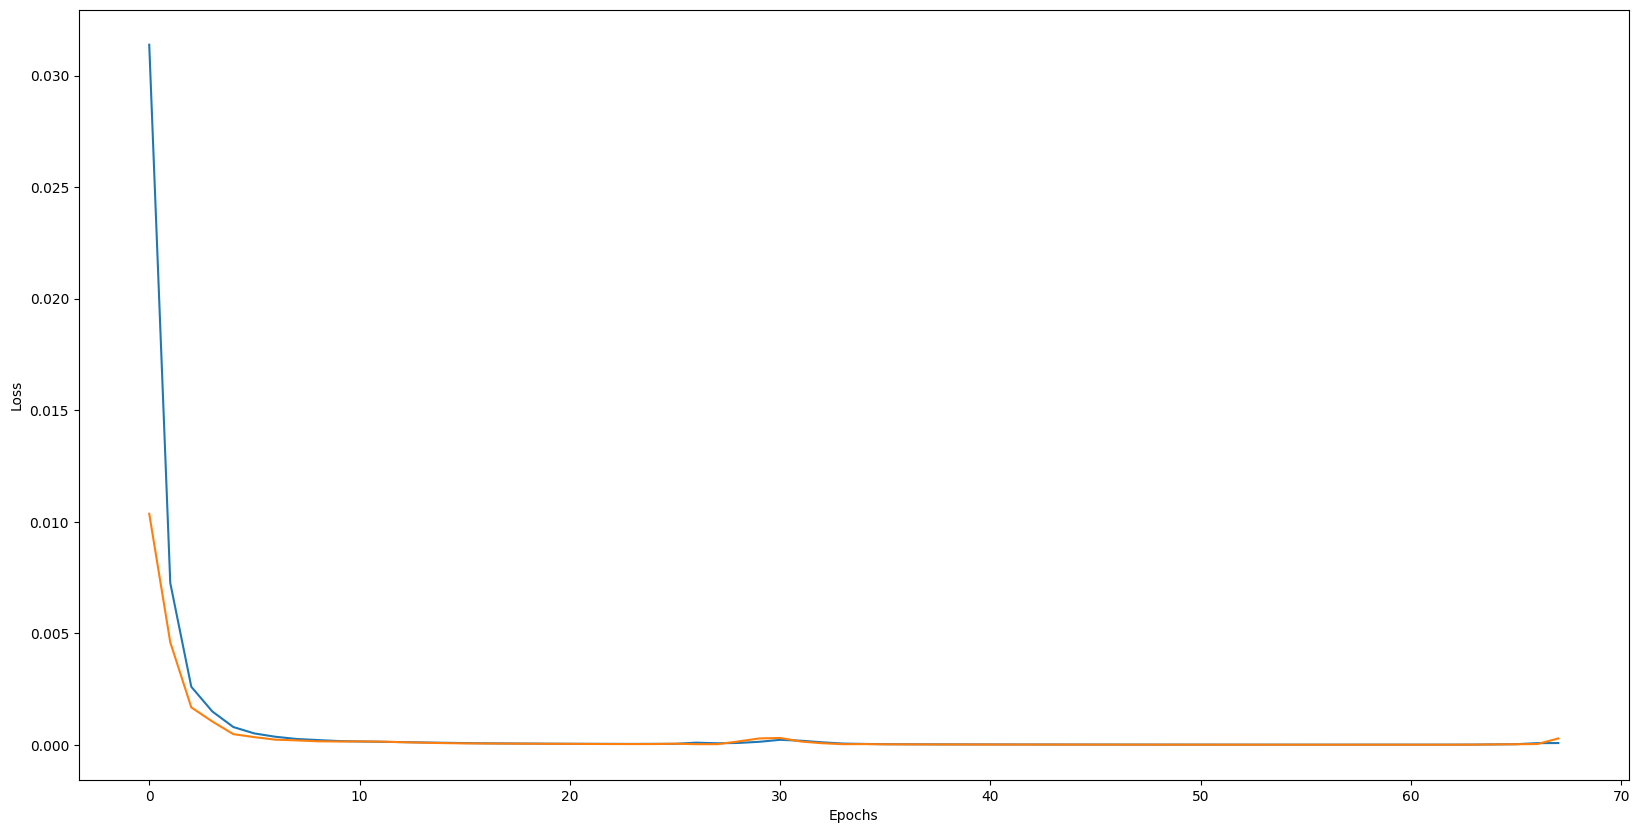

In [17]:
plt.figure(figsize=(20,10))
plt.plot([info_dict[i]['Loss'] for i in info_dict])
plt.plot([info_dict[i]['val_Loss'] for i in info_dict])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

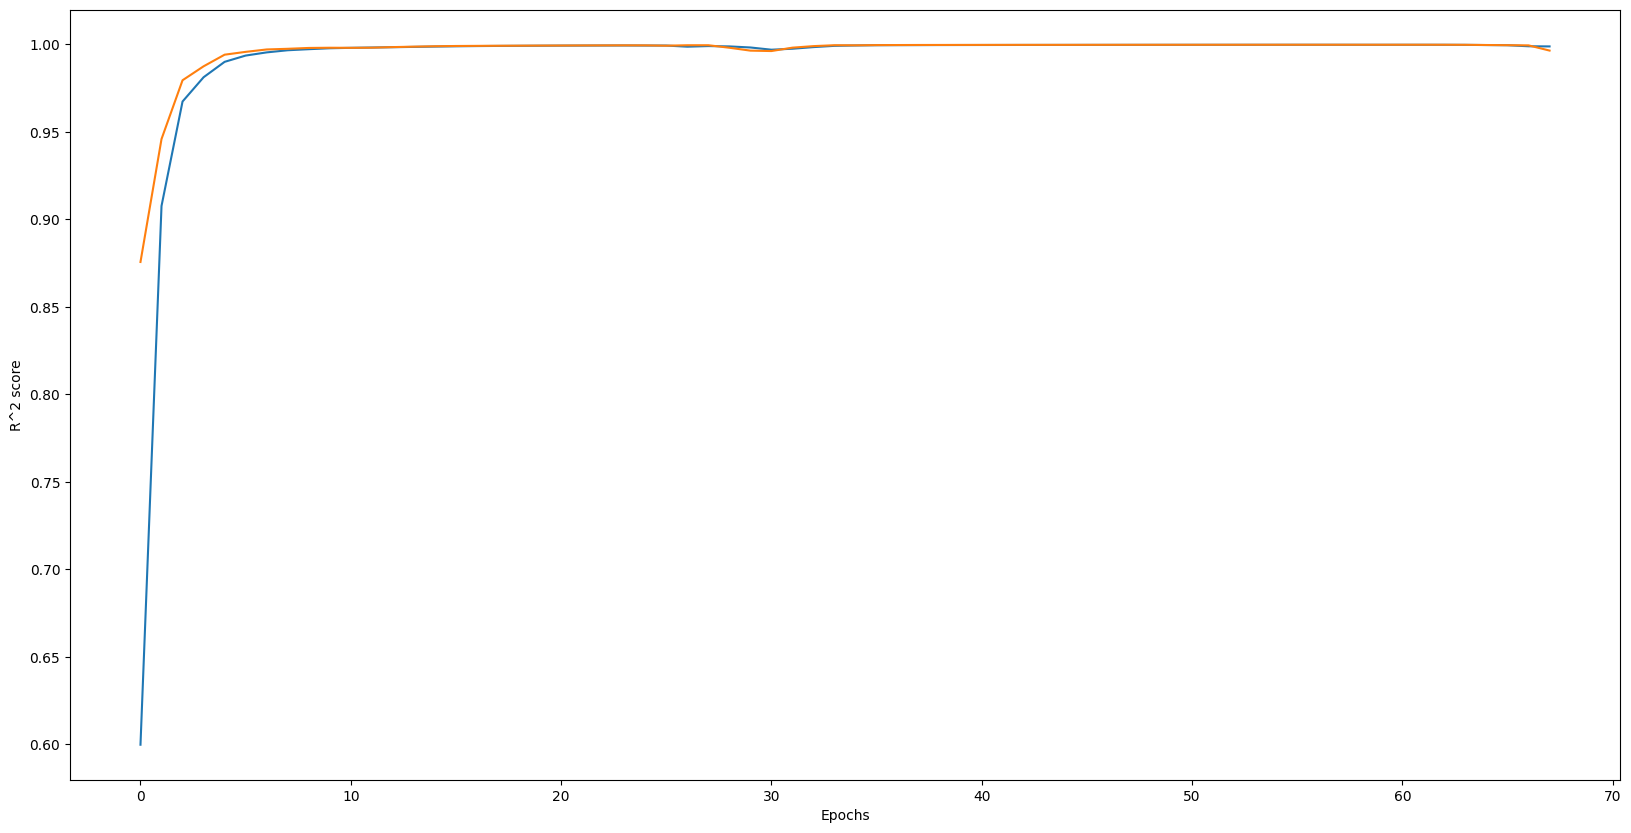

In [18]:
plt.figure(figsize=(20,10))
plt.plot([info_dict[i]['r2_score'] for i in info_dict])
plt.plot([info_dict[i]['val_r2_score'] for i in info_dict])
plt.xlabel('Epochs')
plt.ylabel('R^2 score')
plt.show()